In [1]:
import pandas as pd
import sklearn
print("Pandas version:", pd.__version__)
print("Sklearn version:", sklearn.__version__)

Pandas version: 1.3.4
Sklearn version: 1.0.2


### Data Loading

First, we load all the data from the input files into a single data frame. 
- We first need to list the files in the `return-data` directory. This is done using the `glob` library. We also need to make sure that the data is loaded in the right order. For this we apply `sorted` the the output of `glob`.
- The pandas json read method needs the argument `lines=True` to handle the case in which every line in the input is a json on its own. Otherwise it will assume that the whole file contains only one json.

In [10]:
import glob

dfList = []
for file in sorted(glob.glob("./return-data/*")):
    one_day_df = pd.read_json(file, lines=True)
    dfList.append(one_day_df)
df = pd.concat(dfList).reset_index(drop=True)
df.shape

(31000, 5)

Let's check the distribution of the class label and have a look at the data:

In [11]:
print(df.returnLabel.value_counts())
print("Ratio is:", df[df.returnLabel==1].shape[0]/df.shape[0])
df.head()

0    30711
1      289
Name: returnLabel, dtype: int64
Ratio is: 0.009322580645161291


,transactionId,basket,zipCode,totalAmount,returnLabel
0,2957385223,"[1, 3, 1, 5]",627,192,0
1,4890905342,"[4, 5, 5, 1, 3, 4]",959,96,0
2,3950059852,[4],625,67,0
3,9829252293,[2],368,93,0
4,6828748016,"[4, 4, 3]",575,171,0


### Feature Engineering

We transform the basket into features which have the count of the individual categories as values:

In [12]:
df["c_0"] = df["basket"].map(lambda x: x.count(0))
df["c_1"] = df["basket"].map(lambda x: x.count(1))
df["c_2"] = df["basket"].map(lambda x: x.count(2))
df["c_3"] = df["basket"].map(lambda x: x.count(3))
df["c_4"] = df["basket"].map(lambda x: x.count(4))
df["c_5"] = df["basket"].map(lambda x: x.count(5))

# you can also do the same thing that with a loop:
# for i in range(0, 6):
#     df[f"c_{i}"] = df["basket"].map(lambda x: x.count(i))

In [13]:
df.head()

,transactionId,basket,zipCode,totalAmount,returnLabel,c_0,c_1,c_2,c_3,c_4,c_5
0,2957385223,"[1, 3, 1, 5]",627,192,0,0,2,0,1,0,1
1,4890905342,"[4, 5, 5, 1, 3, 4]",959,96,0,0,1,0,1,2,2
2,3950059852,[4],625,67,0,0,0,0,0,1,0
3,9829252293,[2],368,93,0,0,0,1,0,0,0
4,6828748016,"[4, 4, 3]",575,171,0,0,0,0,1,2,0


For creating the one-hot encoded version of the `zipCode`, we define the dimension of the feature explicitely before we apply the `get_dummies` method. The reason is that we cannot be sure to have seen every possible value of `zipCode` in the training data, but we still want to create a feature for every possible value. Otherwise we would be in trouble in the later prediction phase, if there appears a `zipCode` we have not seen during training.

Note: The values `100` and `1000` in the following line are the theoretical minimum and maximum values of the zipCode. 

In [14]:
df['zipCode'] = pd.Categorical(df['zipCode'], categories=list(range(100, 1001)))
dummies = pd.get_dummies(df.zipCode, prefix='zip')

In [15]:
df2 = pd.concat([df, dummies], axis=1)

In [16]:
df3 = df2.drop(["basket", "zipCode", "transactionId"], axis=1)

In [17]:
df3.head()

,totalAmount,returnLabel,c_0,c_1,c_2,c_3,c_4,c_5,zip_100,zip_101,...,zip_991,zip_992,zip_993,zip_994,zip_995,zip_996,zip_997,zip_998,zip_999,zip_1000
0,192,0,0,2,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,96,0,0,1,0,1,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,67,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,93,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,171,0,0,0,0,1,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Model training

We are now ready to train the model. For this, we split the data into train and test data. To have the test data as the latest available data (as shown on the slides), we set `shuffle=False`.

In [18]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df3, test_size=0.3, shuffle=False)
train.head()

,totalAmount,returnLabel,c_0,c_1,c_2,c_3,c_4,c_5,zip_100,zip_101,...,zip_991,zip_992,zip_993,zip_994,zip_995,zip_996,zip_997,zip_998,zip_999,zip_1000
0,192,0,0,2,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,96,0,0,1,0,1,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,67,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,93,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,171,0,0,0,0,1,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's have a look at the label distribution in the two data sets:

In [19]:
print("Train data: Label ratio is", train[train.returnLabel==1].shape[0]/train.shape[0])
print("Test data: Label ratio is", test[test.returnLabel==1].shape[0]/test.shape[0])

Train data: Label ratio is 0.00944700460829493
Test data: Label ratio is 0.00903225806451613


They are almost equal, which is good. 

In [20]:
X_train = train.drop(columns="returnLabel")
y_train = train["returnLabel"]
X_test = test.drop(columns="returnLabel")
y_test = test["returnLabel"]
X_train.shape

(21700, 908)

In [21]:
X_train.head()

,totalAmount,c_0,c_1,c_2,c_3,c_4,c_5,zip_100,zip_101,zip_102,...,zip_991,zip_992,zip_993,zip_994,zip_995,zip_996,zip_997,zip_998,zip_999,zip_1000
0,192,0,2,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,96,0,1,0,1,2,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,67,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,93,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,171,0,0,0,1,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [23]:
from sklearn.ensemble import GradientBoostingClassifier
gbt = GradientBoostingClassifier()
gbt.fit(X_train, y_train)

GradientBoostingClassifier()

### Model evaluation

Let's check the accuracy

In [24]:
test_scores_reg = logreg.predict(X_test)
test_scores_gbt = gbt.predict(X_test)

In [25]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, test_scores_reg)

0.9918279569892473

In [26]:
accuracy_score(y_test, test_scores_gbt)

0.988494623655914

Let's check the roc curves

In [27]:
test_scores_reg = logreg.predict_proba(X_test)
test_scores_gbt = gbt.predict_proba(X_test)

In [28]:
from sklearn.metrics import auc, roc_curve
fpr_reg, tpr_reg, _ =  roc_curve(y_test, test_scores_reg[:,1])
auc_reg = auc(fpr_reg, tpr_reg)
fpr_gbt, tpr_gbt, _ =  roc_curve(y_test, test_scores_gbt[:,1])
auc_gbt = auc(fpr_gbt, tpr_gbt)

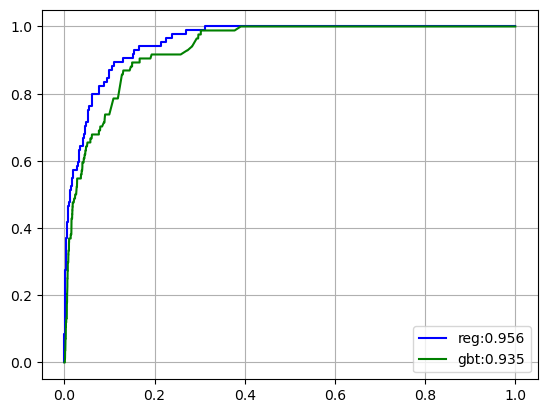

In [29]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_reg, tpr_reg, color='blue', label=f"reg:{auc_reg:.3f}")
plt.plot(fpr_gbt, tpr_gbt, color='green', label=f"gbt:{auc_gbt:.3f}")
plt.legend()
plt.grid()
plt.show()

### Save data and predictions for later exercises

In [22]:
# save data to csv
train.to_pickle("./data/train.pickle")
test.to_pickle("./data/test.pickle")

# save test predictions to csv
df_results = pd.DataFrame(data={'label': y_test, 'predReg': test_scores_reg[:,1], 
                  'predGbt': test_scores_gbt[:,1] })
df_results.to_csv("./data/predictions_test.csv", index=False)

# save train predictions to csv
train_scores_reg = logreg.predict_proba(X_train)
train_scores_gbt = gbt.predict_proba(X_train)
df_results = pd.DataFrame(data={'label': y_train, 'predReg': train_scores_reg[:,1], 
                  'predGbt': train_scores_gbt[:,1] })
df_results.to_csv("./data/predictions_train.csv", index=False)

### Save model for deployment

In [31]:
from joblib import dump

dump(logreg, 'models/logit_model_saved.joblib')


['logit_model_saved.joblib']